# Accuracy Comparison

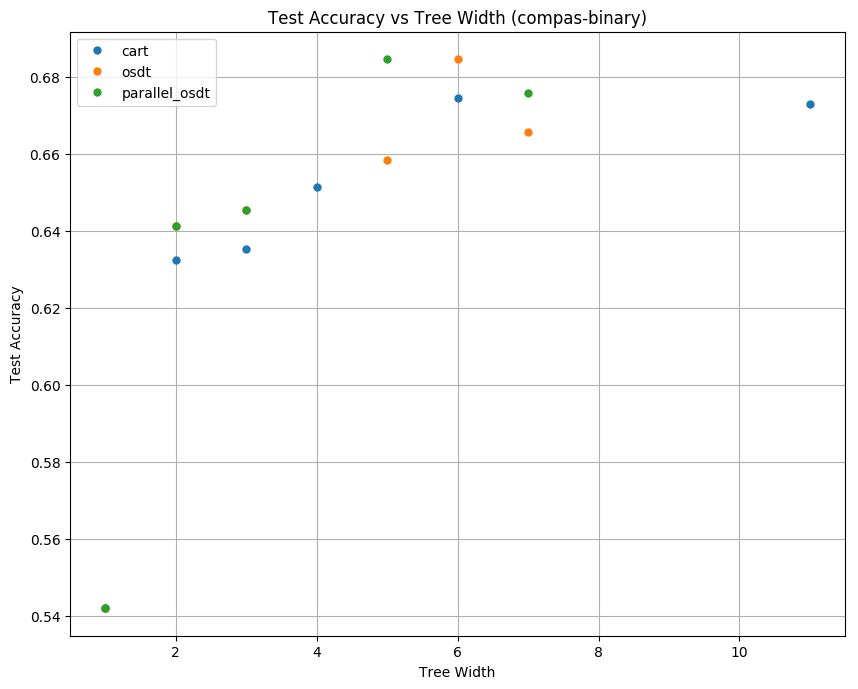

In [2]:
# libraries
from lib.experiments.analysis import plot_accuracy_analysis
 
dataset_name = 'compas-binary'
plot_accuracy_analysis(dataset_name, 'Test Accuracy vs Tree Width ({})'.format(dataset_name))

# Scalability Comparison

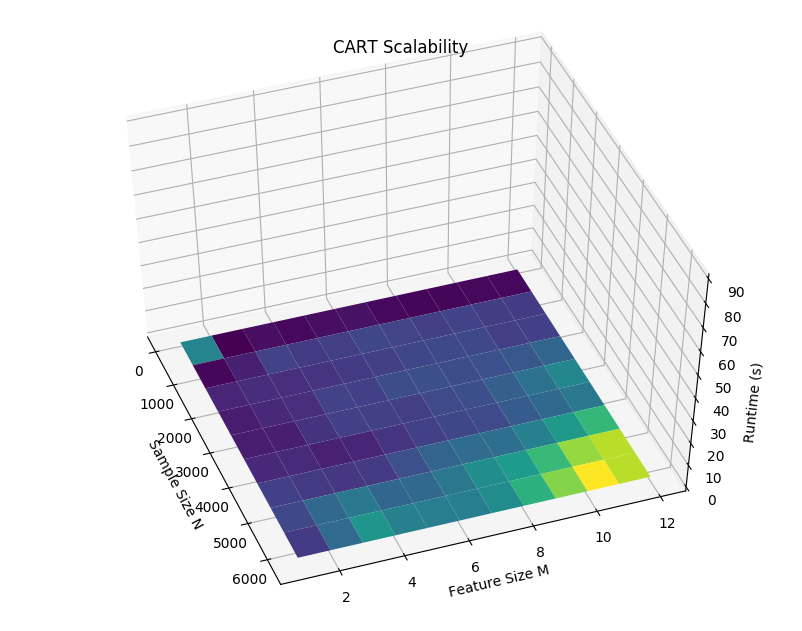

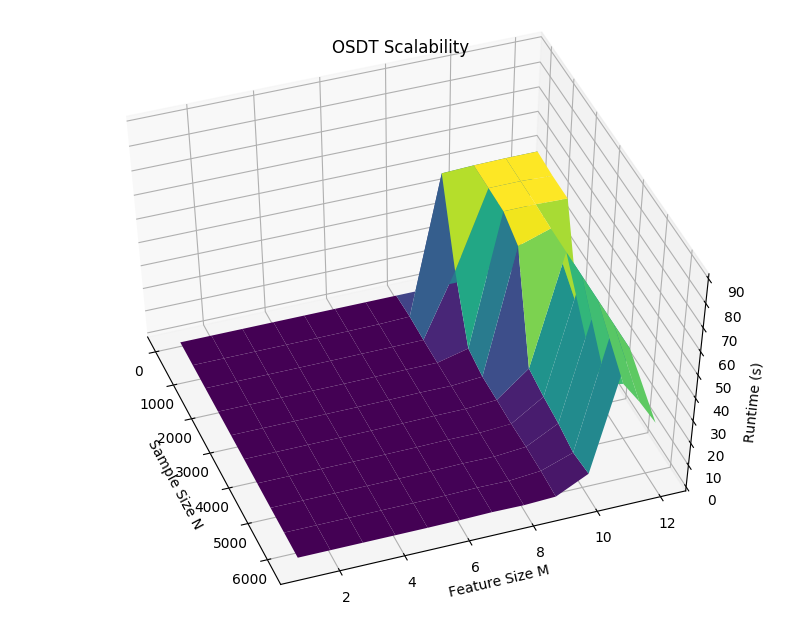

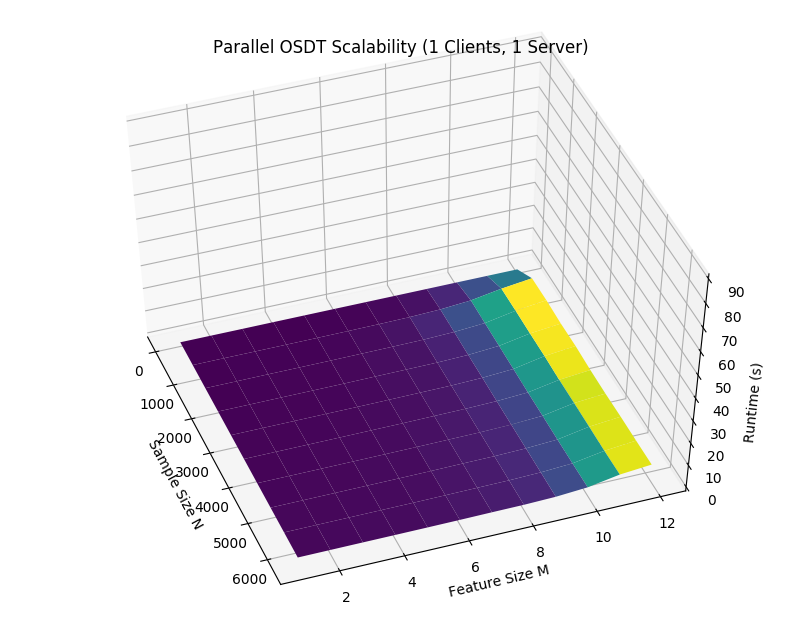

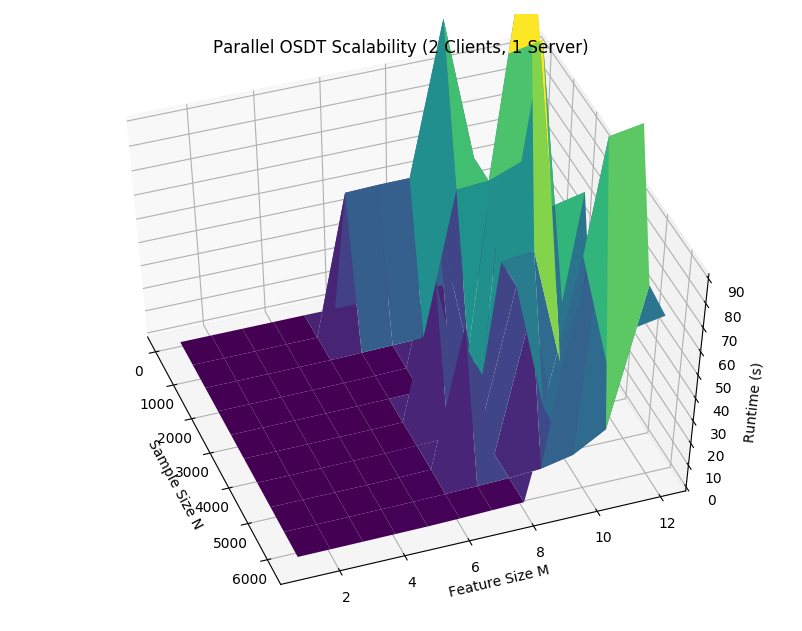

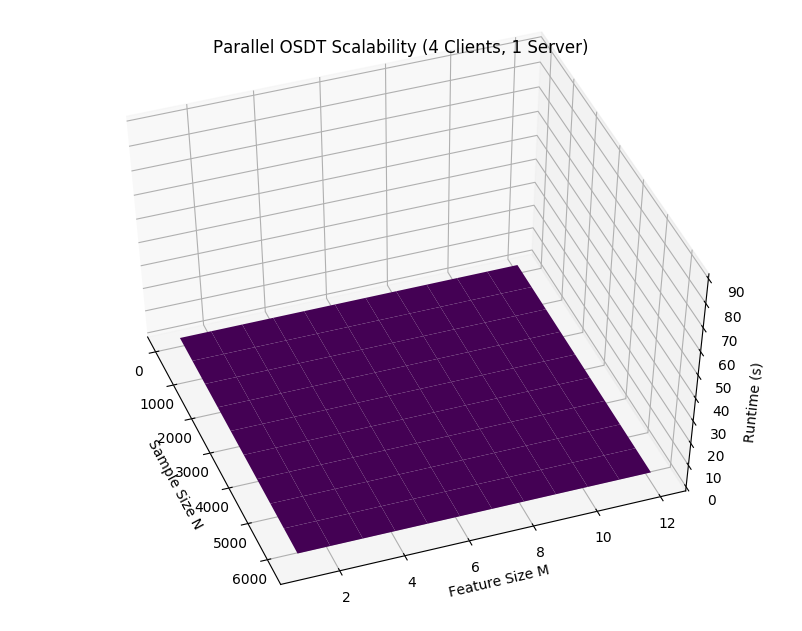

In [10]:
from mpl_toolkits import mplot3d

from lib.data_structures.dataset import read_dataframe
from lib.experiments.analysis import plot_scalability_analysis

dataset_name = 'compas-binary'
timeout = 90

# Scalablity Analysis for CART
dataset = read_dataframe('data/scalability/{}/{}.csv'.format(dataset_name, 'cart'))
plot_scalability_analysis(dataset, 'CART Scalability', z_limit=timeout)

# Scalablity Analysis for OSDT
dataset = read_dataframe('data/scalability/{}/{}.csv'.format(dataset_name, 'osdt'))
plot_scalability_analysis(dataset, 'OSDT Scalability', z_limit=timeout)

# Scalablity Analysis for Parallel OSDT
# for core_count in [1, 2, 4, 8, 16, 32, 60]:
for core_count in [1, 2, 4]:
    dataset = read_dataframe('data/scalability/{}/parallel_osdt_{}_core.csv'.format(dataset_name, core_count))
    plot_scalability_analysis(dataset, 'Parallel OSDT Scalability ({} Clients, 1 Server)'.format(core_count), z_limit=timeout)

# Convergence Rate

Text(0.5,1,'Objective Bounds vs Time')

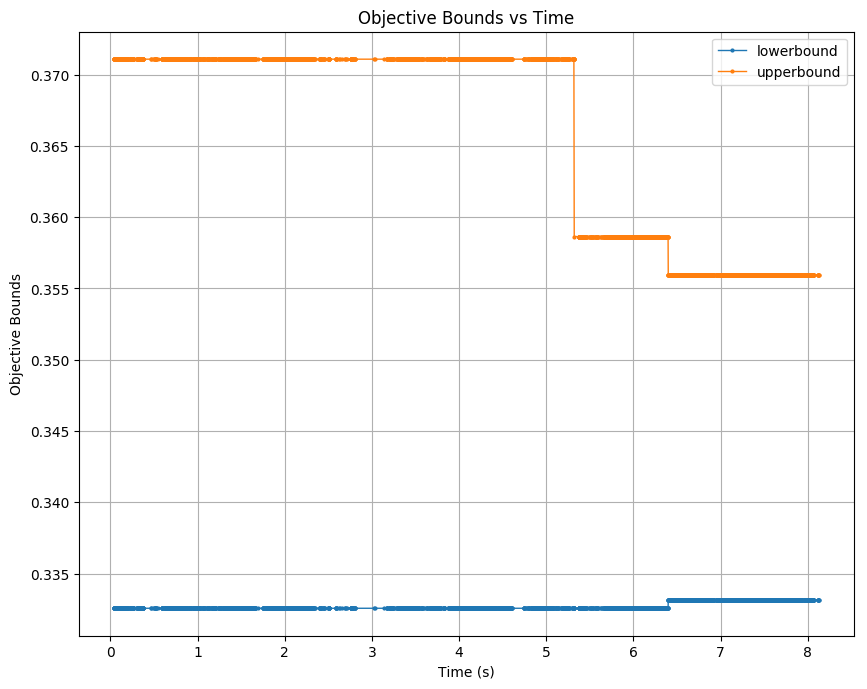

In [7]:
import matplotlib.pyplot as plt

from lib.data_structures.dataset import read_dataframe

dataset = read_dataframe('data/convergence/convergence.csv')
(n, m) = dataset.shape

x = dataset.values[:,0]
y1 = dataset.values[:,1]
y2 = dataset.values[:,2]

fig = plt.figure(figsize=(10, 8), dpi=100)
plt.plot(x, y1, label='lowerbound', markersize=2, marker='o', linewidth=1)
plt.plot(x, y2, label='upperbound', markersize=2, marker='o', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Objective Bounds')
plt.grid()
plt.legend()
plt.title('Objective Bounds vs Time')

# Memory Profile

# Runtime Profile

In [ ]:
import cProfile

# local imports
from lib.models.parallel_osdt_classifier import ParallelOSDTClassifier
from lib.data_structures.dataset import read_dataframe

# Using COMPAS as an example
dataset = read_dataframe('data/preprocessed/compas-binary.csv', sep=";") 
(n, m) = dataset.shape
X = dataset.values[:n,:-1]
y = dataset.values[:n,-1]

hyperparameters = {
    'regularization': 0.005, # Regularization coefficient which effects the penalty on model complexity

    'max_depth': float('Inf'), # User-specified limit on the model
    'max_time': float('Inf'), # User-specified limit on the runtime 

    'workers': 1, # Parameter that varies based on how much computational resource is available

    'visualize': False, # Toggle whether a rule-list visualization is rendered
    'verbose': False, # Toggle whether event messages are printed
    'log': False, # Toggle whether client processes log to logs/work_<id>.log files
    
    'configuration': { # More configurations around toggling optimizations and prioritization options
        'priority_metric': 'uncertainty', # Decides how tasks are prioritized
        'deprioritization': 0.01, # Decides how much to push back a task if it has pending dependencies

        # Note that Leaf Permutation Bound (Theorem 6) is 
        # Toggles the assumption about objective independence when composing subtrees (Theorem 1)
        # Disabling this actually breaks convergence due to information loss
        'hierarchical_lowerbound': True, 
        # Toggles whether problems are pruned based on insufficient accuracy (compared to other results) (Lemma 2)
        'look_ahead': True,
        # Toggles whether a split is avoided based on insufficient support (proxy for accuracy gain) (Theorem 3)
        'support_lowerbound': True,
        # Toggles whether a split is avoided based on insufficient potential accuracy gain (Theorem 4)
        'incremental_accuracy_lowerbound': True,
        # Toggles whether a problem is pruned based on insufficient accuracy (in general) (Theorem 5)
        'accuracy_lowerbound': True,
        # Toggles whether problem equivalence is based solely on the capture set (Similar to Corollary 6)
        'capture_equivalence': True,
        # Hamming distance used to propagate bounding information of similar problems (Theorem 7 + some more...)
        "similarity_threshold": 0,
        # Toggles whether equivalent points contribute to the lowerbound (Proposition 8 and Theorem 9)
        'equivalent_point_lowerbound': True,

        # Toggles compression of dataset based on equivalent point aggregation
        'equivalent_point_compression': True,
        # Toggles whether asynchronous tasks can be cancelled after being issued
        'task_cancellation': True,
        # Toggles whether look_ahead prunes using objective upperbounds (This builds on top of look_ahead)
        'interval_look_ahead': True,
        # Cooldown timer (seconds) on synchornization operations
        'synchronization_cooldown': 0.01
    }
}

model = ParallelOSDTClassifier(**hyperparameters)
model.fit(X, y)
cProfile.run('model.fit(X, y)', sort='tottime')